In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
import torchvision.models as models

# Check if CUDA is available, otherwise use MPS (for Apple Silicon) or CPU
device = torch.device("cuda" if torch.cuda.is_available() else 
                     "mps" if torch.backends.mps.is_available() else 
                     "cpu")
print(f"Using device: {device}")

# Define paths and parameters
IMAGES_PATH = "./data/gtzan/images_original"
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.0003  # Reduced learning rate
NUM_CLASSES = 10

Using device: mps


In [2]:
# Define a proper weight initialization function
def init_weights(m):
    """Initialize network weights using Kaiming initialization"""
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

# Define image transformations with better data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset for GTZAN
class GTZANImageDataset(Dataset):
    """Dataset for GTZAN spectrogram images"""
    def __init__(self, images_path, transform=None, split='train'):
        self.images_path = images_path
        self.transform = transform
        self.split = split
        
        self.genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
                     'jazz', 'metal', 'pop', 'reggae', 'rock']
        
        self.label_map = {genre: i for i, genre in enumerate(self.genres)}
        
        self.files = []
        self.labels = []
        
        # Load all image files and their labels
        for genre in self.genres:
            genre_path = os.path.join(images_path, genre)
            if os.path.exists(genre_path):
                for filename in os.listdir(genre_path):
                    if filename.endswith('.png') or filename.endswith('.jpg'):
                        self.files.append(os.path.join(genre_path, filename))
                        self.labels.append(self.label_map[genre])
        
        # Split data
        if split != 'all':
            train_files, val_files, train_labels, val_labels = train_test_split(
                self.files, self.labels, test_size=0.2, stratify=self.labels, random_state=42
            )
            
            if split == 'train':
                self.files = train_files
                self.labels = train_labels
            else:  # validation
                self.files = val_files
                self.labels = val_labels
        
        print(f"Loaded {len(self.files)} images for {split} split")
        
        # Count instances of each class
        class_counts = {}
        for label in self.labels:
            genre = self.genres[label]
            class_counts[genre] = class_counts.get(genre, 0) + 1
        
        print("Class distribution:")
        for genre, count in class_counts.items():
            print(f"- {genre}: {count} images")
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]
        
        # Load and transform image
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image and the label if there's an error
            blank = torch.zeros((3, 224, 224))
            return blank, label

# Use a pre-trained model with transfer learning instead of defining our own
class VGGishTransfer(nn.Module):
    """VGG16 with transfer learning for audio classification"""
    def __init__(self, num_classes=10):
        super(VGGishTransfer, self).__init__()
        # Load pre-trained VGG16
        self.vgg = models.vgg16(weights='DEFAULT')
        
        # Replace the classifier
        self.vgg.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        
        # Initialize the new classifier layers
        for m in self.vgg.classifier:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.vgg(x)

# Function to verify the data loading
def verify_data():
    # Create a small dataloader to check the data
    temp_dataset = GTZANImageDataset(IMAGES_PATH, transform=val_transforms, split='train')
    temp_loader = DataLoader(temp_dataset, batch_size=4, shuffle=True)
    
    # Get a batch of images
    images, labels = next(iter(temp_loader))
    
    # Print info about the batch
    print(f"Image batch shape: {images.shape}")
    print(f"Labels: {labels}")
    print(f"Genre names: {[temp_dataset.genres[label] for label in labels]}")
    
    # Visualization
    plt.figure(figsize=(15, 10))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        # Denormalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Class: {temp_dataset.genres[labels[i]]}")
    plt.tight_layout()
    plt.show()

# Create validation functions
def check_predictions_distribution(model, val_loader):
    """Check the distribution of predictions on a batch"""
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(val_loader))
        images = images.to(device)
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
        
        # Print prediction distribution
        pred_dist = [predictions.cpu().tolist().count(i) for i in range(NUM_CLASSES)]
        print(f"Prediction distribution: {pred_dist}")
        
        # Check softmax outputs
        softmax_outputs = F.softmax(outputs, dim=1)
        print(f"Average softmax confidence: {softmax_outputs.max(dim=1)[0].mean().item():.4f}")
        print(f"Min softmax range per sample: {(softmax_outputs.max(dim=1)[0] - softmax_outputs.min(dim=1)[0]).min().item():.4f}")

Loaded 799 images for train split
Class distribution:
- jazz: 79 images
- country: 80 images
- rock: 80 images
- hiphop: 80 images
- pop: 80 images
- reggae: 80 images
- metal: 80 images
- blues: 80 images
- classical: 80 images
- disco: 80 images
Loaded 200 images for val split
Class distribution:
- classical: 20 images
- blues: 20 images
- metal: 20 images
- jazz: 20 images
- country: 20 images
- rock: 20 images
- hiphop: 20 images
- reggae: 20 images
- disco: 20 images
- pop: 20 images
Loaded 799 images for train split
Class distribution:
- jazz: 79 images
- country: 80 images
- rock: 80 images
- hiphop: 80 images
- pop: 80 images
- reggae: 80 images
- metal: 80 images
- blues: 80 images
- classical: 80 images
- disco: 80 images
Image batch shape: torch.Size([4, 3, 224, 224])
Labels: tensor([5, 2, 0, 9])
Genre names: ['jazz', 'country', 'blues', 'rock']


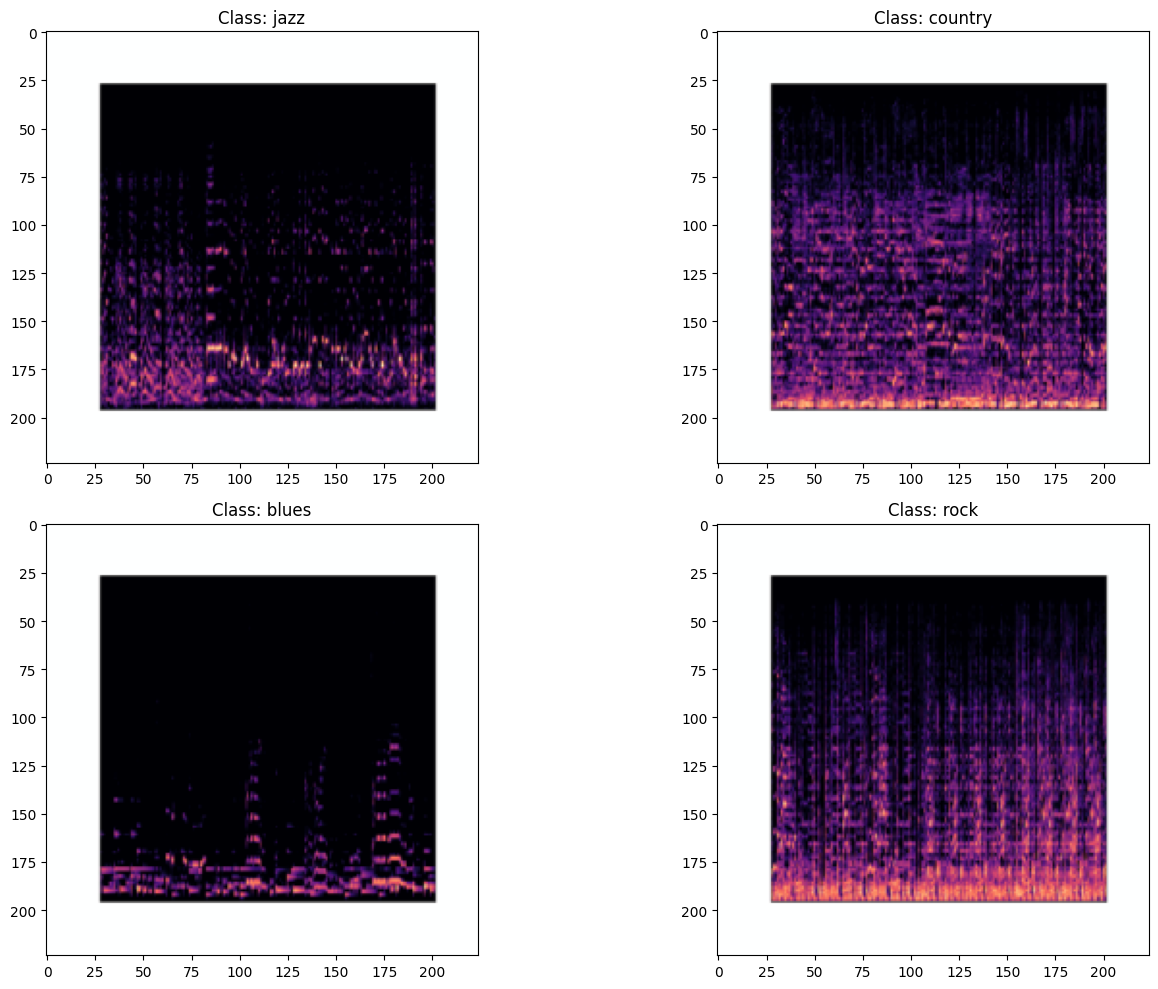

In [6]:
# Initialize datasets
train_dataset = GTZANImageDataset(IMAGES_PATH, transform=train_transforms, split='train')
val_dataset = GTZANImageDataset(IMAGES_PATH, transform=val_transforms, split='val')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Initialize the model
model = VGGishTransfer(num_classes=NUM_CLASSES).to(device)

# Verify data loading
verify_data()

In [7]:
# Calculate class weights for imbalanced data
class_counts = np.zeros(NUM_CLASSES)
for label in train_dataset.labels:
    class_counts[label] += 1

# Convert counts to weights (inverse of frequency)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * NUM_CLASSES  # Normalize
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights.cpu().numpy())

# Define loss function with class weights and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)


Class weights: [0.9987358 0.9987358 0.9987358 0.9987358 0.9987358 1.011378  0.9987358
 0.9987358 0.9987358 0.9987358]


In [8]:
# Training and validation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

# Training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    """Train the model with early stopping"""
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_model_weights = None
    patience = 10  # Number of epochs to wait for improvement
    patience_counter = 0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Check prediction distribution periodically
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            check_predictions_distribution(model, val_loader)
        
        # Save best model by validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            
            # Save model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc
            }, 'best_vggish_model.pth')
            print(f"New best model saved! Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        
        # Print statistics
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
    
    # Load best model weights
    model.load_state_dict(best_model_weights)
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    
    return model, history

# Check predictions distribution before training
print("Initial prediction distribution:")
check_predictions_distribution(model, val_loader)


Initial prediction distribution:
Prediction distribution: [1, 11, 2, 1, 10, 6, 0, 0, 0, 1]
Average softmax confidence: 0.9350
Min softmax range per sample: 0.5114


In [9]:
# Train the model
model, history = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    NUM_EPOCHS, 
    device
)


Epoch 1/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Prediction distribution: [0, 32, 0, 0, 0, 0, 0, 0, 0, 0]
Average softmax confidence: 0.1094
Min softmax range per sample: 0.0177
New best model saved! Val Loss: 2.3040, Val Acc: 0.1000
Train Loss: 15.9695, Train Acc: 0.1039
Val Loss: 2.3040, Val Acc: 0.1000

Epoch 2/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

New best model saved! Val Loss: 2.3034, Val Acc: 0.1000
Train Loss: 2.3113, Train Acc: 0.0839
Val Loss: 2.3034, Val Acc: 0.1000

Epoch 3/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

New best model saved! Val Loss: 2.3028, Val Acc: 0.1000
Train Loss: 2.3100, Train Acc: 0.0876
Val Loss: 2.3028, Val Acc: 0.1000

Epoch 4/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3077, Train Acc: 0.0964
Val Loss: 2.3030, Val Acc: 0.1000

Epoch 5/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3098, Train Acc: 0.0876
Val Loss: 2.3029, Val Acc: 0.1000

Epoch 6/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Prediction distribution: [0, 0, 0, 0, 0, 32, 0, 0, 0, 0]
Average softmax confidence: 0.1043
Min softmax range per sample: 0.0124
Train Loss: 2.3083, Train Acc: 0.0914
Val Loss: 2.3033, Val Acc: 0.1000

Epoch 7/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3062, Train Acc: 0.1101
Val Loss: 2.3028, Val Acc: 0.1000

Epoch 8/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3089, Train Acc: 0.0964
Val Loss: 2.3032, Val Acc: 0.1000

Epoch 9/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

New best model saved! Val Loss: 2.3027, Val Acc: 0.1000
Train Loss: 2.3063, Train Acc: 0.0839
Val Loss: 2.3027, Val Acc: 0.1000

Epoch 10/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3049, Train Acc: 0.0914
Val Loss: 2.3027, Val Acc: 0.1000

Epoch 11/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Prediction distribution: [0, 32, 0, 0, 0, 0, 0, 0, 0, 0]
Average softmax confidence: 0.1024
Min softmax range per sample: 0.0057
Train Loss: 2.3055, Train Acc: 0.0989
Val Loss: 2.3027, Val Acc: 0.1000

Epoch 12/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3114, Train Acc: 0.0788
Val Loss: 2.3027, Val Acc: 0.1000

Epoch 13/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3088, Train Acc: 0.0939
Val Loss: 2.3028, Val Acc: 0.1000

Epoch 14/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3065, Train Acc: 0.1039
Val Loss: 2.3027, Val Acc: 0.1000

Epoch 15/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3071, Train Acc: 0.0889
Val Loss: 2.3028, Val Acc: 0.1000

Epoch 16/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Prediction distribution: [0, 0, 0, 0, 0, 0, 32, 0, 0, 0]
Average softmax confidence: 0.1030
Min softmax range per sample: 0.0063
Train Loss: 2.3052, Train Acc: 0.0939
Val Loss: 2.3028, Val Acc: 0.1000

Epoch 17/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

New best model saved! Val Loss: 2.3027, Val Acc: 0.1000
Train Loss: 2.3071, Train Acc: 0.0839
Val Loss: 2.3027, Val Acc: 0.1000

Epoch 18/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

New best model saved! Val Loss: 2.3026, Val Acc: 0.1000
Train Loss: 2.3053, Train Acc: 0.1089
Val Loss: 2.3026, Val Acc: 0.1000

Epoch 19/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

New best model saved! Val Loss: 2.3026, Val Acc: 0.1000
Train Loss: 2.3069, Train Acc: 0.0839
Val Loss: 2.3026, Val Acc: 0.1000

Epoch 20/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

New best model saved! Val Loss: 2.3026, Val Acc: 0.1000
Train Loss: 2.3061, Train Acc: 0.0839
Val Loss: 2.3026, Val Acc: 0.1000

Epoch 21/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Prediction distribution: [0, 0, 0, 0, 32, 0, 0, 0, 0, 0]
Average softmax confidence: 0.1015
Min softmax range per sample: 0.0026
Train Loss: 2.3053, Train Acc: 0.0951
Val Loss: 2.3026, Val Acc: 0.1000

Epoch 22/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3037, Train Acc: 0.1001
Val Loss: 2.3026, Val Acc: 0.1000

Epoch 23/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3048, Train Acc: 0.0851
Val Loss: 2.3026, Val Acc: 0.1000

Epoch 24/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3039, Train Acc: 0.1064
Val Loss: 2.3026, Val Acc: 0.1000

Epoch 25/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3041, Train Acc: 0.0826
Val Loss: 2.3026, Val Acc: 0.1000

Epoch 26/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Prediction distribution: [0, 0, 0, 0, 32, 0, 0, 0, 0, 0]
Average softmax confidence: 0.1014
Min softmax range per sample: 0.0024
Train Loss: 2.3046, Train Acc: 0.1114
Val Loss: 2.3026, Val Acc: 0.1000

Epoch 27/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3031, Train Acc: 0.1089
Val Loss: 2.3026, Val Acc: 0.1000

Epoch 28/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3009, Train Acc: 0.1264
Val Loss: 2.3026, Val Acc: 0.1000

Epoch 29/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 2.3064, Train Acc: 0.0989
Val Loss: 2.3026, Val Acc: 0.1000

Epoch 30/30


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Prediction distribution: [0, 0, 0, 0, 32, 0, 0, 0, 0, 0]
Average softmax confidence: 0.1014
Min softmax range per sample: 0.0023
Early stopping triggered at epoch 30
Best validation accuracy: 0.1000


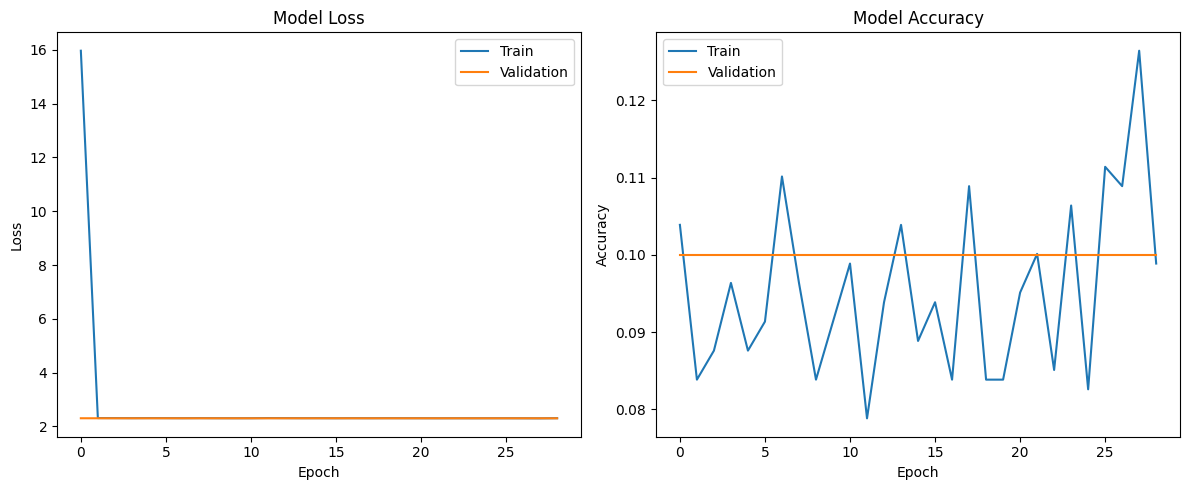

Validating:   0%|          | 0/7 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

       blues     0.0000    0.0000    0.0000        20
   classical     0.0000    0.0000    0.0000        20
     country     0.0000    0.0000    0.0000        20
       disco     0.0000    0.0000    0.0000        20
      hiphop     0.1000    1.0000    0.1818        20
        jazz     0.0000    0.0000    0.0000        20
       metal     0.0000    0.0000    0.0000        20
         pop     0.0000    0.0000    0.0000        20
      reggae     0.0000    0.0000    0.0000        20
        rock     0.0000    0.0000    0.0000        20

    accuracy                         0.1000       200
   macro avg     0.0100    0.1000    0.0182       200
weighted avg     0.0100    0.1000    0.0182       200



/Users/jan/git/wimu/AudioConcept/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jan/git/wimu/AudioConcept/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jan/git/wimu/AudioConcept/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

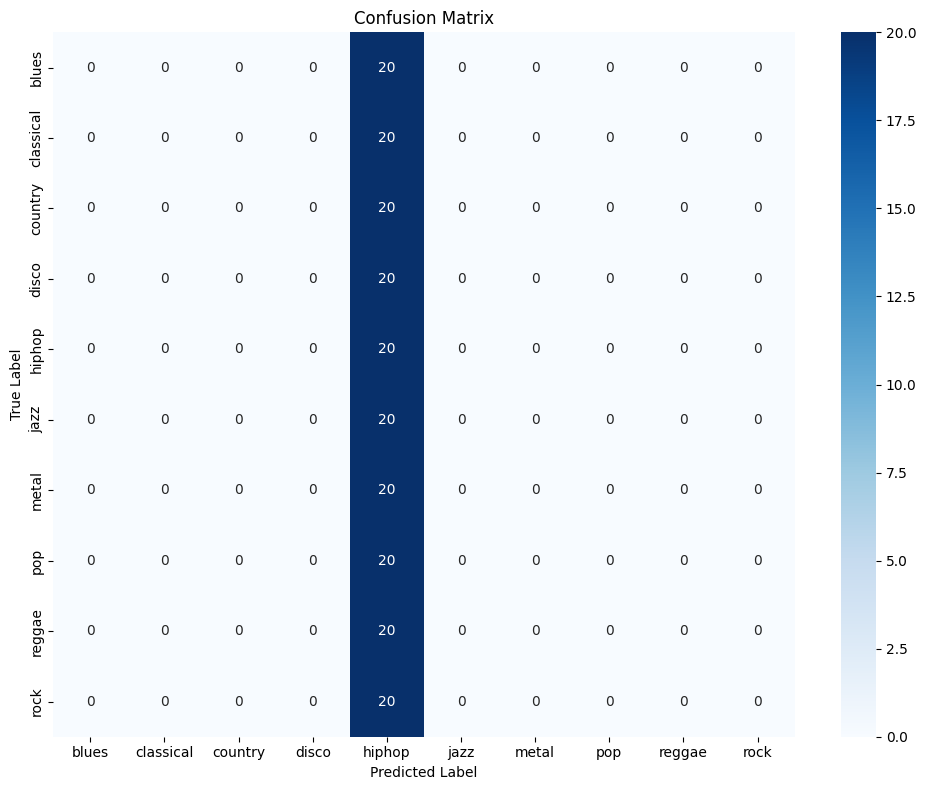

In [10]:
# Visualize training history
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate final model on validation set
val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)

# Print classification report
print("\nClassification Report:")
print(classification_report(
    val_labels, 
    val_preds, 
    target_names=train_dataset.genres,
    digits=4
))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.genres,
            yticklabels=train_dataset.genres)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
    'history': history
}, 'vggish_gtzan_final.pth')